# Chapter 7 - Minimum, Maximum, and Mixture

Let's look at the distribution of minima, maxima, and also looking at distributions that are mixtures of other distrubutions.

## Cumulative Distribution Functions
- So far: Pmf (probability mass distribution)
- CDF (Cumulative distribution function)

Here's the Euro problem again:

<AxesSubplot:>

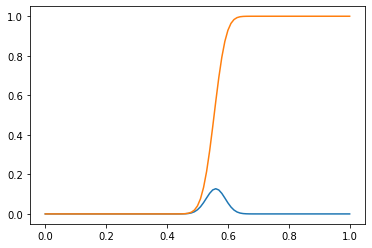

In [1]:
import numpy as np
from empiricaldist import Pmf
from scipy.stats import binom

hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

# now the update
def update_binomial(pmf, data):
    """ Update the PMF using the binomial distribution """
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()
    
update_binomial(pmf, data)

# The CDF is the cumulative sum of the PMF, so...
cumulative = pmf.cumsum()
pmf.plot()
cumulative.plot()

In [2]:
cumulative[0.61]

0.9638303193984255

So there is about a 96% chance that the value is <= 0.61

To go the other way, we can use interpolation.

In [3]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

`empiricaldist` includes a `Cdf` class to represent this. Given a `Pmf`, you can calulate it as follows:

In [4]:
cdf = pmf.make_cdf()

# select an element using square brackets:
cdf[0.61]

0.9638303193984255

In [5]:
# But that will throw a KeyError if not in the CDF - use () to use interpolation
cdf(0.615)

array(0.96383032)

In [6]:
# use quantile to calculate the probability:
cdf.quantile(0.96)

array(0.61)

In [7]:
# and use credible_interval to calculate... the credible interval
cdf.credible_interval(0.9)

array([0.51, 0.61])

In [8]:
# You can also create a Pmf from a Cdf:
cdf.make_pmf()

,probs
0.00,0.000000e+00
0.01,1.256330e-207
0.02,5.731921e-166
0.03,8.338711e-142
0.04,8.269265e-125
...,...
0.96,0.000000e+00
0.97,0.000000e+00
0.98,0.000000e+00
0.99,0.000000e+00


## Best Three of Four

In DnD, each character has six attributes. To general a new character, roll 4 D6 and add up the best three.

In [ ]:
def make_dice(num_sides):
    pmf = Pmf(1, range(1, num_sides + 1))
    pmf.normalize()
    return pmf

def add_dist_seq(*pmfs):
    pmf = pmfs[0]
    for other_pmf in pmfs[1:]:
        pmf = Pmf.add_dist(pmf, other_pmf)
    pmf.normalize()
    return pmf

If we were just rolling three dice, then computing the distribution of their sum would be trivial. *But* doing it for the case for rolling four and taking the best three is more complicated. Let's do a quick simulation:

In [ ]:
n = 100000
a = np.random.randint(1, 7, size=(n, 4))
a.sort(axis=1) # sort in ascending order
t = a[:, 1:].sum(axis=1) # select the last three columns and add them up
pmf_best_3 = pmf.from_seq(t) # calculates the PMF
pmf_best_3.plot()

# also, let's compare this just the sum of three
d6 = make_dice(6)
sum_3 = add_dist_seq(d6, d6, d6)
sum_3.plot()
add_dist_seq(d6).plot()

Unsuprisingly, taking the best 3 of 4 results in roughly the same shape, but skewed right.

## Maximum

To calculate the distribution of the maximum of the best 3 of 4, we can use the Cdf:

In [ ]:
cdf_best_3 = pmf_best_3.make_cdf()

Recall that the CDF captures the probability that a randomly chosen value is <= x. If we are drawing 6 values, the probability that they are all <= x is CDF(x) ** 6. If all 6 are <= x, then their maximum is also <= x.

In [ ]:
from empiricaldist import Cdf

cdf_max_6 = Cdf(cdf_best_3 ** 6)
sum_3.make_cdf().plot()
cdf_max_6.plot()
cdf_best_3.plot()

In [ ]:
# Cdf also has this build in as max_dist(n):
cdf_max_dist_6 = cdf_best_3.max_dist(6)
cdf_max_dist_6.plot()

## Minimum

How can we figure out the minimum?

In [ ]:
prob_gt = 1 - cdf_best_3

prob_gt_6 = prob_gt ** 6
prob_le_6 = 1 - prob_gt_6
cdf_min_6 = Cdf(prob_le_6)
cdf_min_6.plot()

In [ ]:
# Also a method to calculate it directly
cdf_min_dist_6 = cdf_best_3.min_dist(6)

## Mixture

Let's calculate a distribution that is a mixture of other distributions!

- Character is armed with a dagger in one hand and a short sword in the other
- Randomly choose one each round to attack with
- dagger causes D4 of damage; short sword D6

What is the distribution of damage each round?

In [ ]:
def make_die(num_sides):
    pmf = Pmf(1, range(1, num_sides + 1))
    pmf.normalize()
    return pmf
    
d4 = make_die(4)
d6 = make_die(6)

We could loop through each possibility and calculate `(d4(n) + d6(2)) / 2`, or just use the + operator on the Pmfs:

In [ ]:
mix1 = (d4 + d6) / 2
mix1.plot(kind="bar")

Now suppose you are being attacked by three monsters:
- One has a club: D4
- One has a mace: D6
- One has a quarterstaff: D6

Only one attacks per round. What is the distribution of damage?

In [ ]:
mix2 = (d4 + 2 * d6) / 3
mix2.plot(kind="bar")

## General Mixtures

Previously we mixed distributions in an ad-hoc way. Let's continue with our example to develop a general solution:

Three more monsters join the fight, each with a battle axe (D8):

- 1 D4
- 2 D6
- 3 D8

PMF to represent a randomly chosen monster:

In [ ]:
hypos = [4, 6, 8]
counts = [1, 2, 3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

Above represents the probability of choosing a dice with that many sides. 

Now let's make a sequence of Pmf objects representing the dice:

In [ ]:
dice = [ make_dice(sides) for sides in hypos]

Now let's compute the weighted average of the dice, using the probabilities in pmf_dice as the weights:

In [ ]:
import pandas as pd
table = pd.DataFrame(dice)
table

In [ ]:
pd.DataFrame(dice).fillna(0)

The next step is to multiply each row (representing a single dice type) by the probabilities in pmf_dice; this is easier if we take the transpose:

In [ ]:
df = pd.DataFrame(dice).fillna(0).transpose()
df *= pmf_dice.ps
df

In [ ]:
# add up the weighted distributions
df.sum(axis=1)

In [ ]:
df.sum(axis=1).plot(kind="bar")

In [ ]:
# putting it all together
def make_mixture(pmf, pmf_seq):
    """
    Make a mixture of distributions
    
    Arguments:
        pmf: The Pmf that maps from each hypothesis to a probability
        pmf_seq: A sequence of Pmf objects, one for each hypothesis
    """
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

## Exercises

### Excercise 7-1

> When you generate a character, instead of rolling, you can choose a 'standard array' of attributes: 15, 14, 13, 12, 10, 8. Do you think you are better off rolling or using the standard?
>
> Compare the distribution of the values in the standard array to the distribution that computed for the best three of four:
> - Which distribution has the higher mean? Use the `mean` method
> - Which distribution has the higher standard deviation? Use the `std` method
> - The lowest value in the standard array is 8. For each attribute, what is the probability of getting a value less than 8? If you roll a dice six times, what's the probability that at least one of your attributes is less than 8?
> - The highest value in the standard array is 15. For each attribute, what is the probability of getting a value greater than 15? If you roll a dice 6 times, what's the probability that at least one of your attributes is greater than 15?

### Solution

In [ ]:
standard_array = [15, 14, 13, 12, 10, 8]
standard_array_mean = sum(standard_array) / len(standard_array)
print(f"Mean of standard array: {standard_array_mean}")

In [ ]:
# generate the data
num_experiments = 10000
data = np.random.randint(1, 7, size=(num_experiments, 4))
data.sort(axis=1)
t = data[:, 1:].sum(axis=1)
pmf_best_3 = Pmf.from_seq(t)
print(f"Mean of best 3: {pmf_best_3.mean()}")

In [ ]:
# standard deviation of the standard array
standard_std = np.std(standard_array)
print(f"Standard deviation of the standard array: {standard_std}")

In [ ]:
# standard deviation
print(f"Standard deviation of the best 3 of 4: {pmf_best_3.std()}")

In [ ]:
cdf_best_3 = pmf_best_3.make_cdf()
prob_less_8 = cdf_best_3[7]
print(f"Probability of any one of the attributes being less than 8 is {prob_less_8}")

In [ ]:
# Probability that at least one is less than 8:
# 1 - P(All >= 8)
# 1 - P(any particular > 8) ** 6
# 1 - (1 - Cdf(7)) ** 6
p = 1 - (1 - prob_less_8) ** 6
print(f"Probability that at least one will be less than 8: {p}")

In [ ]:
# Probability of getting a value > 15?
prob_gt_15 = 1 - cdf_best_3[15]
print(f"Probability of any attribute being greater than 15: {prob_gt_15}")

# Prob that at least one is > 15?
# P(all <= 15)
# P(one <= 15) ** 6
# Cdf(15) ** 6
prob_at_least_one_gt_15 =  1 - (cdf_best_3[15]) ** 6
print(f"Probability that at least one is greater than 15: {prob_at_least_one_gt_15}")

### Exercise 7-2

> Suppose that you are fighting three monsters:
> - Short sword: 1D6
> - Battle axe: 1D8
> - Bastard sword: 1D10
> 1. One of the monsters attacks you and does 1 damage. Which one do you think it was? Compute the posterior probability that each monster was the attacker
> 2. If the same monster attacks you again, what is the probability that you suffer 6 points of damage?
> Hint: compute a posterior distribution as we have done before and pass it as one of the arguments to `make_mixture`

In [ ]:
hypos = [6, 8, 10]
prior = Pmf(1, hypos)
prior.normalize()
likelihood = 1 / prior.qs
posterior = prior * likelihood
posterior.normalize()
posterior.plot(kind="bar")

In [ ]:
d6 = make_dice(6)
d8 = make_dice(8)
d10 = make_dice(10)

mix = make_mixture(posterior, (d6, d8, d10))
mix.normalize()
mix.plot(kind="bar")
print(f"Chance of rolling a 6: {mix[6]}")

### Exercise 7-3

> Henri Poincare suspected that a local bakery was selling loaves that were lighter than the advertised 1kg. Collected data: normally distributed, mean 950g, sd 50g. The police gave the baker a warning.
>
> He continues to collect data. Now the mean was 1kg, but the distribution is skewed, consistent with light bread but giving Henri the heavier ones.
>
> Let's test out the plausibility of this. Say the baker hefts `n` loaves and gives the heaviest to Henri. How many would he have to heft to have the mean work out to 1kg?

In [ ]:
pmfs = {}
num_samples = 1000
max_hefts = 5
for num_heft in range(1, max_hefts + 1):
    samples = np.random.normal(950, 50, size=(num_samples, num_heft))
    samples.sort(axis=1)
    highests = samples.max(axis=1)
    Cdf.from_seq(highests).plot()
    print(f"Heft {num_heft}: Mean {highests.mean()}")
    